In [1]:
# Imports.

import os
import json
import gzip
import urllib.request
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import model_selection

pd.options.mode.chained_assignment = None

## Data Sampling and Collection

This dataset contains product reviews and metadata from Amazon, including reviews spanning May 1996 - July 2014.
This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). 

### Download and load the data into dataframes:

Utility functions:

In [2]:
def load_data(url, filename):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)
        
    # Load the data.
    data = []
    with gzip.open(filename) as f:
        for l in f:
            data.append(json.loads(l.strip()))
    
    df = pd.DataFrame.from_dict(data)
    print('data shape:', df.shape)
    print('first rows of data:')
    display(df.head(3))
    return df

def get_metadata_with_ratings(reviews, metadata):
    ratings = reviews[['asin', 'overall']].groupby('asin').agg('mean').rename(columns={'overall': 'rating'})
    metadata_with_ratings = metadata.merge(ratings, how="left", on="asin")
    
    # Check how many products have ratings.
    print('distribution of ratings:')
    display(metadata_with_ratings['rating'].describe())
    print('number of missing ratings:', metadata_with_ratings['rating'].isnull().sum())
    return metadata_with_ratings

#### Metadata


In [3]:
url ='http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz'
filename = "../data/meta_All_Beauty.json.gz"
metadata = load_data(url,filename)    

data shape: (32892, 18)
first rows of data:


,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",[],,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162


#### Reviews

In [4]:
url ='http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/All_Beauty.json.gz'
filename = "../data/All_Beauty.json.gz"
reviews = load_data(url,filename) 

data shape: (371345, 12)
first rows of data:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN


#### Merging `Reviews` and `Metadata`

In [5]:
metadata_with_ratings = get_metadata_with_ratings(reviews, metadata)

distribution of ratings:


count    32890.000000
mean         4.040421
std          1.144289
min          1.000000
25%          3.500000
50%          4.428571
75%          5.000000
max          5.000000
Name: rating, dtype: float64

number of missing ratings: 2


#### `reviews` attributes:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product
#### `metadata` attributes:
- title - name of the product
- feature - bullet-point format features of the product
- description - description of the product
- price - price in US dollars (at time of crawl)
- image - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to
- tech1 - the first technical detail table of the product
- tech2 - the second technical detail table of the product
- similar - similar product table

Reviews dataset is only used for EDA, not modeling purposes.

## Data Cleaning

#### Granularity: 
The granularity of `metadata` is a single product and the granularity for `reviews` dataset is a single review.

#### Cleaning and filtering:

In [6]:
# This cleaning procedure is recommended by the documentation
metadata = metadata.fillna('')
unform = metadata[metadata.title.str.contains('getTime')] # unformatted rows
print(len(metadata))
print(len(unform))
# Turns out there are no unformatted rows

32892
0


Cleaning utility function:

In [7]:
def describe_feat(data, feat, as_int=False):
    description = data[feat].describe()
    if as_int:
        description = description.astype(int)
    display(description)
    print(f'number of missing {feat}s:', data[feat].isnull().sum())

def clean_features(metadata_with_ratings, training_data=None, output=True):
    if training_data is None:
        training_data = metadata_with_ratings
    # Clean price.
    metadata_with_ratings['price_float'] = pd.to_numeric(
            metadata_with_ratings['price'].str.replace('$', ''), errors='coerce')
    if output:
        describe_feat(metadata_with_ratings, 'price_float')    
    
    # Clean sales rank.
    metadata_with_ratings['rank_float'] = pd.to_numeric(metadata_with_ratings['rank'].str.replace(',', '') \
                                                      .str.extract('^(\d+)', expand=False), errors='coerce')
    if output:
        describe_feat(metadata_with_ratings, 'rank_float', as_int=True)
    
    # Add sales rank category.
    metadata_with_ratings['rank_category'] = metadata_with_ratings['rank'] \
                .str.extract(' in (.+) \(', expand=False) \
                .str.replace('&amp;', '&')
    if output:
        print('categories:')
        print(metadata_with_ratings['rank_category'].value_counts())
    
    # Clean reviews
    
    
    # Clean description.
    metadata_with_ratings['description_str'] = metadata_with_ratings['description'].str.join('\n')
    
    # Clean brand.
    brand_counts = training_data['brand'].value_counts().iloc[1:]
    metadata_with_ratings['brand_count'] = pd.to_numeric(metadata_with_ratings['brand'].replace(brand_counts),
                                                         errors='coerce').fillna(0)
    if output:
        describe_feat(metadata_with_ratings, 'brand_count')
    metadata_with_ratings['top_brand'] = (metadata_with_ratings['brand_count'] > 20).astype(int)
    if output:
        print('percentage top brand:', metadata_with_ratings['top_brand'].mean())
        
def transform_col(data, func, feat, new_feat):
    data[new_feat] = func(metadata_with_ratings[feat])
    data[new_feat].describe()

In [8]:
clean_features(metadata_with_ratings)

count    11268.000000
mean        27.745949
std         47.096857
min          0.010000
25%          8.990000
50%         15.990000
75%         29.990000
max        999.990000
Name: price_float, dtype: float64

number of missing price_floats: 21624


count      32452
mean     1288189
std       815171
min           35
25%       677521
50%      1133461
75%      1751104
max      9549407
Name: rank_float, dtype: int64

number of missing rank_floats: 440
categories:
Beauty & Personal Care       32380
Grocery & Gourmet Food          38
Health & Household              21
Sports & Outdoors                3
Toys & Games                     3
Baby                             2
Clothing, Shoes & Jewelry        2
Tools & Home Improvement         1
Automotive                       1
Home & Kitchen                   1
Name: rank_category, dtype: int64


count    32892.000000
mean         7.751094
std         26.280731
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        252.000000
Name: brand_count, dtype: float64

number of missing brand_counts: 0
percentage top brand: 0.08318132068588106


#### Cleaning operations performed:

- `price`: Extracted the price value as a float into `price_float`
- `sales rank`: 
    - Extracted the rank value as a float into `rank_float`
    - Created a new attribute called `rank_category`
- `description`: Removed \n from the descriptions
- `Brand`: Added `brand_counts`, the number of products sold by that brand

Indeed, products with missing price do exist. We now decide on whether we remove these products from the review dataset or we keep them and try coming up with a approximation for their price.
Let's check what proportion of the product dataset is missing a price:

In [9]:
print("About ",metadata_with_ratings[np.isnan(metadata_with_ratings['price_float'])].shape[0]/metadata_with_ratings.shape[0] * 100,"% products are missing a price value")

About  65.74242977015687 % products are missing a price value


This proportion is very huge. Let's see if we can identify a pattern in the product metadata for missing prices during EDA.

Transformations:

In [10]:
transform_col(metadata_with_ratings, np.log, 'rank_float', 'log_rank')
transform_col(metadata_with_ratings, np.sqrt, 'rank_float', 'sqrt_rank')
transform_col(metadata_with_ratings, lambda x: x * x, 'price_float', 'sq_price')
transform_col(metadata_with_ratings, lambda x: x * x, 'brand_count', 'sq_brand_count')

#### Filtering operations performed

In [11]:
# Remove products with incorrect rank
metadata_beauty = metadata_with_ratings.query('rank_category == "Beauty & Personal Care"')
metadata_beauty.shape

(32380, 29)

In [12]:
# Remove products with out price, which likely means the product is no longer available.
metadata_available = metadata_beauty[~np.isnan(metadata_beauty['price_float'])]
metadata_available.shape

(11112, 29)

## Exploratory Data Analysis

Utility functions:

In [13]:
def plot_joint_reg(data, x, y, title='', plot_figure=True):
    if plot_figure:
        sns.jointplot(data=data, x=x, y=y, kind='reg',
                      scatter_kws={'alpha': 0.1, 's': 15}, line_kws={'color': 'r'}) \
                .fig.suptitle(title)
    data_cleaned = data.query(f'not {x}.isnull() and not {y}.isnull()')
    X = data_cleaned[x].to_numpy()[:,None]
    model = LinearRegression().fit(X, data_cleaned[y])
    print(f'y = {model.intercept_} + {model.coef_[0]} * x, r^2 = {model.score(X, data_cleaned[y])}')

#### 1. Missing Prices

In this section we try and address the missing prices:

In [14]:
noprice = metadata[metadata['price'] =='']
withprice = metadata[metadata['price'] !='']
brands_no_price = noprice['brand'].value_counts(dropna=False).to_frame().reset_index()
brands_no_price.columns = ['brand','no_price']
brands_with_price = withprice['brand'].value_counts(dropna=False).to_frame().reset_index()
brands_with_price.columns = ['brand','with_price']

Checking if not having prices is a brand specific pattern or product specific. If this is not specific to a brand, we can use the average price for all the products of a brand to assign the missing price. Unfortuately, if there is a brand with no products priced, we will have to discard that data as the proportion of products with missing price data is already very big and making assumptions will skew the data.

`price_exist` is a dataframe with `brand` name,`total` # products, # products with price (`with_price`), # products without price(`no_price`) and a boolean feature which is `True` if the brand has both priced and unpriced products otherwies `False`.

In [15]:
price_exist = metadata['brand'].value_counts(dropna=False).to_frame().reset_index()
price_exist.columns = ['brand','total']
price_exist.head()

price_exist = price_exist.merge(brands_with_price,how = 'left',on = 'brand').merge(brands_no_price,how = 'left',on = 'brand')

In [16]:
price_exist.head()
price_exist.fillna(0)

,brand,total,with_price,no_price
0,,15673,3664.0,12009.0
1,VAGA,252,197.0,55.0
2,L'Oreal Paris,113,58.0,55.0
3,Philips Norelco,88,21.0,67.0
4,Gillette,83,15.0,68.0
...,...,...,...,...
7858,Kendall,1,1.0,0.0
7859,Mytee Mitt,1,0.0,1.0
7860,Hoeleen,1,0.0,1.0
7861,CICATRICURE,1,1.0,0.0


In [17]:
metadata[metadata['brand'] == 'Gillette'].head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
48,[],,"[Gillettes strong, sustained growth in blades ...",,Gillette SensorExcel Cartridges (Pack of 15),[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"2,896,468 in Beauty &amp; Personal Care (",[],"{'Shipping Weight:': '2.5 pounds', 'Domestic S...",All Beauty,,,,B0000530JE
56,[],,"[, A revolutionary new <b>triple-blade shaving...",,Gillette MACH3 Shaving Cartridges (12 Cartridges),[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"1,615,438 in Beauty &amp; Personal Care (",[],"{'Shipping Weight:': '2.4 ounces (', 'Domestic...",All Beauty,,,$31.90,B00005355V
57,[],,[Formulated with Tea Tree Oil to penetrate and...,,"The Gillette Series Shave Gel, Deep Clean, 7-O...",[],[],,Gillette,[],"3,170,859 in Beauty & Personal Care (",[],"{' Item Weight: ': '11.4 ounces', 'Sh...",All Beauty,,,,B0000532E2
84,[],,[World's best shave. The next generation tripl...,,Gillette Mach3 Turbo Cartridges with Aloe &amp...,[],[],,Gillette,[],"1,359,849 in Beauty & Personal Care (",[],"{'Shipping Weight:': '3.2 ounces (', 'Domestic...",All Beauty,,,$21.05,B000065AB1
85,[],,[Get a close and comfortable with Gillette Ser...,,Gillette Series Extra Comfort Shave Gel 7 Oz (...,[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"1,410,174 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '2.1 x 2.1 ...,All Beauty,,,,B000065AB6


In [18]:
print(metadata.query("brand== 'Gillette'").loc[57,'description'],"\n")
print(metadata.query("brand== 'Gillette'").loc[57,'title'])


['Formulated with Tea Tree Oil to penetrate and clean, and deliver the protection and comfort you need for healthy looking skin. No other shaving foam or gel provides a closer, smoother, more comfortable shave. Gillette Series - Advanced protection and comf'] 

The Gillette Series Shave Gel, Deep Clean, 7-Ounce Bottle (Pack of 6)


The above product is no longer sold by Gillette on Amazon. Most of the products that are missing prices are the ones that are no longer available on Amazon.

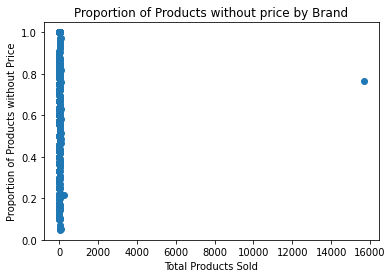

In [19]:
plt.scatter(price_exist['total'],price_exist['no_price']/price_exist['total'],)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by Brand");


The extreme right point is the one with missing brand name. It probably represents unbranded products. We can disregard those products for now. And to reduce overplotting, we can change the limits of x axis.

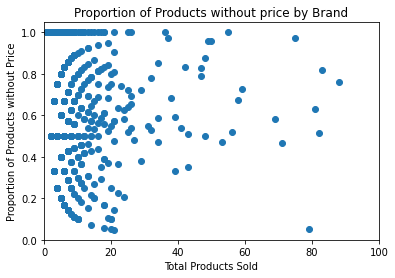

In [20]:
plt.scatter(price_exist['total'],price_exist['no_price']/price_exist['total'],)
plt.xlim(0,100)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by Brand");

But this plot includes a lot of brands which only ever sold a few products and then shut down. Let's just look at the active brands. These are the brands which have atleast a few products with prices.

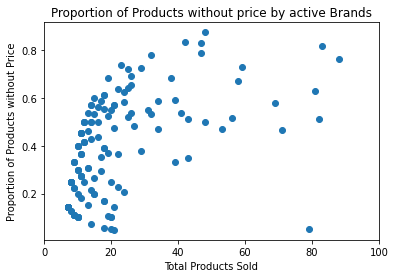

In [21]:
filtered = price_exist['with_price']>5
x = price_exist.loc[filtered,'total']
y = price_exist.loc[filtered,'no_price']/price_exist.loc[filtered,'total']
plt.scatter(x,y)
plt.xlim(0,100)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by active Brands");

There is a positive correlation between the total number of products sold by active brands and the proportion of product without prices. This tells us that larger the brand the quicker they upgrade their inventory on Amazon.

#### 2. Extracting the sentiment of the reviews

We will now proceed with extracting the sentiment from the reviews. We will then compare it with the rating and see what correlations we expect. One should expect a positive correlation. We will then compare sentiment against the prices

We shall be using VADER. The cell below loads the data containing all sentiments into a dataframe called `sent`

In [22]:
vader_file = "../data/vader_lexicon.txt"
print(''.join(open(vader_file).readlines()[:10]))
sent = pd.read_csv(vader_file,sep = '\t',index_col=0,header=None, usecols = [0,1], names = ['token',"polarity"])
sent.head()

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


Let's again look at the `reviews` dataframe

In [23]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


We are interested in the `reviewText`

Before moving ahead we need to first remove all the punctuation. Below is a regex which will capture all the punctuations within text.

In [24]:
punct_re = r'[^\w_\s]'

def sanitize_texts(df):
    punct_re = r'[^\w_\s\n]'    
    df["clean_text"] = df['reviewText'].str.lower().str.replace(punct_re," ",regex = True)
    df["clean_summary"] = df['summary'].str.lower().str.replace(punct_re," ",regex = True)
    return df

reviews = sanitize_texts(reviews)
reviews["clean_text"].head()

0                                                great
1    my  husband wanted to reading about the negro ...
2    this book was very informative  covering all a...
3    i am already a baseball fan and knew a bit abo...
4    this was a good story of the black leagues  i ...
Name: clean_text, dtype: object

In [25]:
reviews["unixReviewTime"].value_counts()

1456790400    515
1468800000    469
1468454400    430
1461024000    426
1462147200    412
             ... 
1016064000      1
1076284800      1
1105056000      1
1007856000      1
1119225600      1
Name: unixReviewTime, Length: 5288, dtype: int64

It seems our review dataset doesn't have a primary key. Let's create one!!

In [26]:
reviews["primary_key"] = reviews.index

In [27]:
reviews["primary_key"].value_counts()

2047      1
316111    1
271057    1
277202    1
275155    1
         ..
3499      1
13740     1
15789     1
9646      1
0         1
Name: primary_key, Length: 371345, dtype: int64

We ended up using the index as our primary key.

In [28]:
def to_tidy_format(df):
    tidy = (
        df["clean_text"]
        .str.split()
        .explode()
        .to_frame()
        .rename(columns={"clean_text": "word"})
    )
    return tidy

tidyReviewText = to_tidy_format(reviews)
tidyReviewText.head()

,word
0,great
1,my
1,husband
1,wanted
1,to


Adding in the Polarity Score:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each review: we can join the table with the lexicon table. 

In [29]:
def add_polarity(df, tidy_df):
    df["polarity"] = (
        tidy_df
        .merge(sent, how='left', left_on='word', right_index=True)
        .reset_index()
        .loc[:, ['index', 'polarity']]
        .groupby('index')
        .sum()
        .fillna(0)
    )
    return df

reviews = add_polarity(reviews, tidyReviewText)
reviews.query("polarity<0")

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,clean_text,clean_summary,primary_key,polarity
9,1.0,True,"11 19, 2016",AMACNEW14ADMX,014789302X,rabiyaa123,it burns your eyes when u put it on and very ...,i do not recommend.,1479513600,3,NaN,NaN,it burns your eyes when u put it on and very ...,i do not recommend,9,-1.8
94,5.0,True,"02 28, 2018",AAVTF1ADARRTU,1620213982,Henry Sanchez,Its the right size for the right product. Its...,Perfect Holder for my razor and brush,1519776000,NaN,{'Size:': ' 6.25 Inches'},NaN,its the right size for the right product its...,perfect holder for my razor and brush,94,-1.6
156,5.0,True,"12 17, 2017",A122O00K0Y3ET3,1620213982,Michael T.,It's fine. Wanted to order a replacement for t...,It's fine. Wanted to order a replacement for t...,1513468800,NaN,{'Size:': ' 6.25 Inches'},NaN,it s fine wanted to order a replacement for t...,it s fine wanted to order a replacement for t...,156,-2.3
186,4.0,True,"10 31, 2017",A2D2P3PXKRDVZ8,1620213982,Gutz-42,I have had it a couple of weeks and works fine...,... have had it a couple of weeks and works fi...,1509408000,NaN,{'Size:': ' 6.25 Inches'},NaN,i have had it a couple of weeks and works fine...,have had it a couple of weeks and works fi...,186,-0.9
189,2.0,True,"10 25, 2017",A25NTNX0RLFZD3,1620213982,Robert McLeod,My shving brush was too large in diameter. Tr...,Do not adjust,1508889600,NaN,{'Size:': ' 6.25 Inches'},NaN,my shving brush was too large in diameter tr...,do not adjust,189,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371299,1.0,True,"05 22, 2017",A29I4UGV40K8QO,B01HI75KNE,NICOLE SALMON,"The dryer is a disappointment, too heavy , but...","The dryer is a disappointment, too heavy",1495411200,NaN,NaN,NaN,the dryer is a disappointment too heavy but...,the dryer is a disappointment too heavy,371299,-4.4
371329,1.0,True,"04 21, 2017",A31CW6M6DOT894,B01HJ1K3YK,Cookie,Very misleading advertising. The price is onl...,One Star,1492732800,NaN,NaN,NaN,very misleading advertising the price is onl...,one star,371329,-1.7
371336,2.0,True,"06 27, 2018",AF3SZ7YB5M3Q5,B01HJEGTYK,Deb Magelssen,It's hard to match hair color.,It's hard to match hair color.,1530057600,NaN,NaN,NaN,it s hard to match hair color,it s hard to match hair color,371336,-0.4
371340,1.0,True,"07 20, 2017",A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,1500508800,NaN,NaN,NaN,it was awful it was super frizzy and i tried ...,it was super frizzy and i tried to comb it and...,371340,-0.9


With the polarity in place, let's see how polarity correlates with rating. We'll first do so without grouping by product and just focus on reviews.

(-100.0, 100.0)

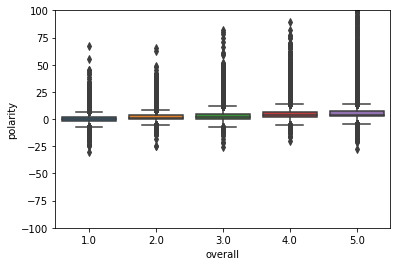

In [30]:
sns.boxplot(x="overall",y ="polarity",data = reviews)
plt.ylim(-100,100)

This is as one would expect that the polarity of reviews would go up as the rating increases. Indeed, this is the case. Let's compare the correlation now for verified and non-verified users separately and we focus only on the IQR regions and not worry about outliers.

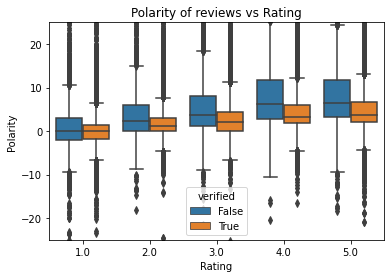

In [31]:
sns.boxplot(x="overall",y ="polarity",data = reviews, hue = 'verified')
plt.ylim(-25,25)
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.title("Polarity of reviews vs Rating");

Verified users have a narrower IQR. This is because number of verified users is way more than the number of unverified users. Hence, more variability is encountered in unverified users response.

In [32]:
reviews['verified'].value_counts()

True     322473
False     48872
Name: verified, dtype: int64

#### 3. Sales Rank vs Avg Rating

To make sure what we want to use as the training label, we narrowed down two candidates: Amazon product category sales rank, and the average review rating. To do this, we will explore the relationship of these two variables in the following three plots. Because of the peculiar structure of sales rank, which is heavily right-skewed, we tried using the log, square root, and raw values of sales rank.

y = 5.284418015933039 + -0.0869981262699975 * x, r^2 = 0.008155288972740316


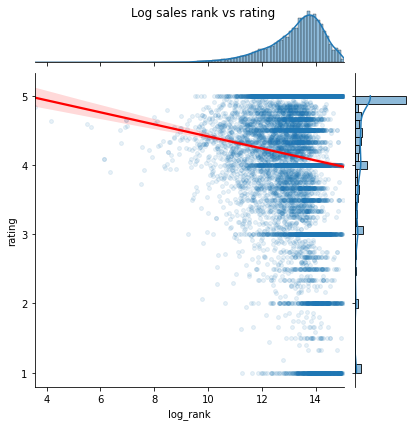

In [33]:
plot_joint_reg(data=metadata_available, x='log_rank', y='rating', title='Log sales rank vs rating')

y = 4.382677813068544 + -0.0002955502765685041 * x, r^2 = 0.010600651080946988


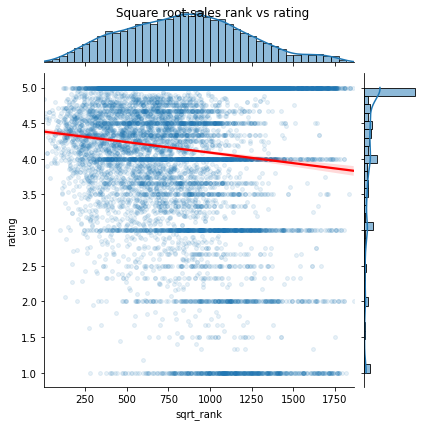

In [34]:
plot_joint_reg(data=metadata_available, x='sqrt_rank', y='rating', title='Square root sales rank vs rating')

y = 4.2721684776024125 + -1.644824791467768e-07 * x, r^2 = 0.010927900297228677


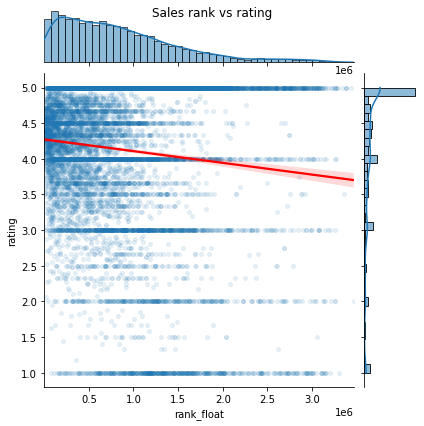

In [35]:
plot_joint_reg(data=metadata_available, x='rank_float', y='rating', title='Sales rank vs rating')

As we can see, the sales rank is distributed most evenly when a square root transformation is applied, so we will be using the square root sales rank from now on. Regardless, there is a negative correlation between sales rank and rating. This makes sense, because products with higher ratings are likely to sell better. However, the correlation is not very strong: only about 1% of variance in the rating is explained by sales rank. This shows that neither value alone is enough to infer the other, so we must decide which variable is more important for us to predict.

We decided to predict the square root sales rank, because any seller is likely to be more concerned about sales revenue. In addition, it has a wider range of values, whereas the rating only ranges from 1 to 5, so it might cause trouble for linear models.

#### Price vs Sales Rank

We will now explore the relationship between the price and square root sales rank.

y = 807.2550407336856 + 1.6200095615238648 * x, r^2 = 0.006911986252966518


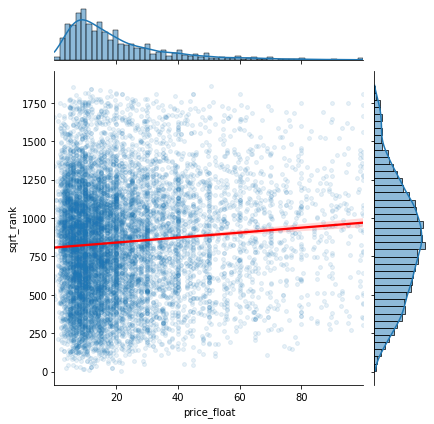

In [36]:
price_truncated = metadata_available.query('price_float < 100')
plot_joint_reg(data=price_truncated, x='price_float', y='sqrt_rank')

Interestingly, there is a positive correlation between the two, which means more expensive products tend to sell worse. The correlation is very weak, but the residuals do not appear to form any pattern, meaning we do not need to further explore a more complicated relationship. This makes sense, because many factors other than price affect the sales performance. This preliminary analysis suggests that the price will be a useful feature to predict the sales rank, though we cannot jump to any conclusions before training the model.

#### Brand

We now explore the effect of the product brand on the sales rank. First, we graph the frequency certain brands appear in our data.

VAGA                 197
EG GIFTS              74
L'Oreal Paris         57
Betty Dain            40
Victoria's Secret     38
Bath & Body Works     29
Revlon                28
Unknown               28
Rimmel                28
Sally Hansen          27
Name: brand, dtype: int64

Text(0.5, 1.0, 'Frequency of occurence for brands, from most to least common')

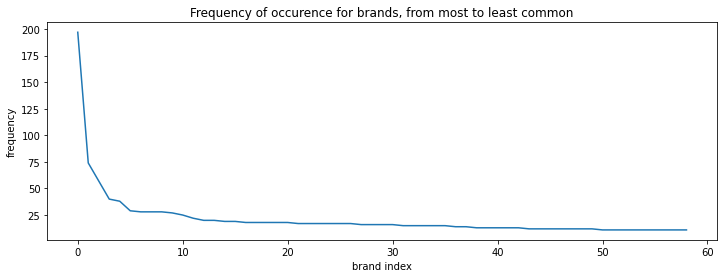

In [37]:
brand_counts = metadata_available['brand'].value_counts().iloc[1:] # Remove blank ''.
display(brand_counts[:10])

brand_counts_filtered = brand_counts[brand_counts > 10]
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(brand_counts_filtered)), brand_counts_filtered)
plt.ylabel('frequency')
plt.xlabel('brand index')
plt.title('Frequency of occurence for brands, from most to least common')

Next we plot the relationship between the number of times a product's brand appears vs the square root rank.

y = 842.7190379408572 + 0.561942980162603 * x, r^2 = 0.0030795426671067494


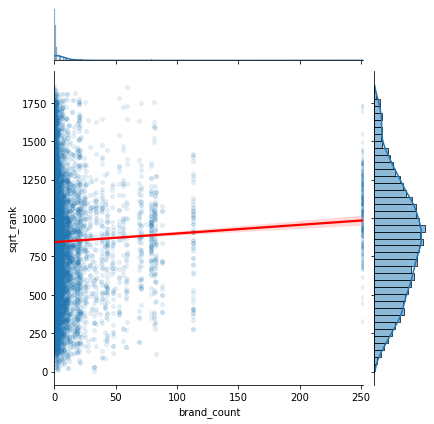

In [38]:
plot_joint_reg(data=metadata_available, x='brand_count', y='sqrt_rank')

We also explore whether a brand appearing over 20 times in the data makes it sell better.

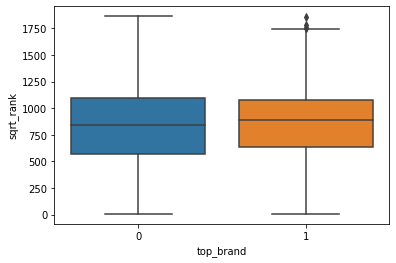

In [39]:
sns.boxplot(data=metadata_available, x='top_brand', y='sqrt_rank');

From the above analysis, it appears that a few brands appear very frequently, while many other brands only occur in a few products. In addition, frequent brands seem to actually sell worse on average than infrequent brands, though with an extremely weak correlation. The brand count and top brand indicator are likely useful for prediction, but the one hot encoding for brand is likely also needed to take full advantage of the brand information.

#### Is there any correlation between the variables you are interested in exploring?
Correlations explored:
1. Proportion of products by brand in the dataset without prices vs total products sold by that brand:
   We observed that there was poitive correlation. Which meand uf a brand sold a larger number of products, it will have more products without prices. This shows that larger brands have to keep upgrading their inventory on Amazon to thrive.
2. Polarity of ReviewText vs Rating: Positive correlation
3. Square Root Sales Rank vs Average Rating: Negative correlation, but very weak.
4. Price vs Square Root Sales Rank: Positive correlation, but weak.
5. Brand Frequency vs Square Root Sals Rank: Positive correlation, very weak.

## Modeling

Modeling Utility functions:

In [40]:
def extract_words(data, feat, max_words=100, encoder=None, output=True):
    if not encoder:
        encoder = CountVectorizer(max_features=max_words, stop_words='english')
        encoder.fit(data[feat])
    X = encoder.transform(data[feat]).toarray()

    if output:
        print('first 50 features:', encoder.get_feature_names()[:50])
        print('feature matrix shape', X.shape)
    return X, encoder

def onehot_encode(data, feat, max_categories=100, encoder=None):
    cat_counts = data[feat].value_counts()
    categories = cat_counts[1:max_categories + 1].index.tolist()
    raw_features = data[feat].to_numpy()[:,None]
    if not encoder:
        encoder = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse=False)
        encoder.fit(raw_features)
    return encoder.transform(raw_features), encoder

def fill_missing(data, feat, imputer=None):
    if not imputer:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

def standardize(X, scale_columns, encoder=None, output=True):
    X_to_scale = X[:,scale_columns]
    if not encoder:
        encoder = StandardScaler()
        encoder.fit(X_to_scale)
    X[:,scale_columns] = encoder.transform(X_to_scale)
    if output:
        print('mean:', encoder.mean_)
        print('standard deviation:', encoder.scale_)
    return X, encoder

numerical_features = ['price_float', 'sq_price', 'brand_count', 'sq_brand_count', 'top_brand']
standardize_cols = [0, 1, 2, 3] # Column indexes that should be standardized.

def get_feat_matrix(data, encoders=None):
    if not encoders:
        encoders = [None, None, None, None]
    X1 = data[numerical_features].to_numpy()
    X2, encoders[0] = onehot_encode(data, 'brand', encoder=encoders[0])
    X3, encoders[1] = extract_words(data, 'title', encoder=encoders[1], output=False)
    X4, encoders[2] = extract_words(data, 'description_str', 500, encoder=encoders[2], output=False)
    X = np.hstack([X1, X2, X3, X4])
    X, encoders[3] = standardize(X, standardize_cols, encoder=encoders[3], output=False)
    return X, encoders

def get_feature_names(encoders):
    features = np.append(numerical_features, encoders[0].get_feature_names())
    features = np.append(features, np.char.add('title_', encoders[1].get_feature_names()))
    features = np.append(features, np.char.add('descr_', encoders[2].get_feature_names()))
    return features

def train_test_split(data, label):
    data_train, data_test, y_train, y_test = \
            model_selection.train_test_split(data, data[label], test_size=0.2, random_state=314)
    clean_features(data_train, training_data=data_train, output=False)
    clean_features(data_test, training_data=data_train, output=False)
    X_train, encoders = get_feat_matrix(data_train)
    X_test, _ = get_feat_matrix(data_test, encoders=encoders)
    print(f'Training data of shape {X_train.shape}, test data {X_test.shape}')
    return X_train, X_test, y_train, y_test, encoders

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mean_proportional_error(y, y_pred):
    return np.sqrt(np.mean(((y - y_pred) / y)**2))

def train_ridge(X_train, X_test, y_train, y_test):
    alpha_exponents = np.arange(-5, 5, 0.2) * np.log(10)
    model = RidgeCV(alphas=np.exp(alpha_exponents))
    return train_model(X_train, X_test, y_train, y_test, model)
    
def train_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_loss = rmse(y_train, y_train_pred)
    test_loss = rmse(y_test, y_test_pred)
    train_err = mean_proportional_error(y_train, y_train_pred)
    test_err = mean_proportional_error(y_test, y_test_pred)
    
    print('training r^2:', train_r2)
    print('test r^2:', test_r2)
    print('training loss:', train_loss)
    print('test loss:', test_loss)
    print('training proportional loss:', train_err)
    print('test proportional loss:', test_err)
    return model

Train-test data split, 80/20.

In [41]:
label = 'sqrt_rank'

In [42]:
X_train, X_test, y_train, y_test, encoders = train_test_split(metadata_available, label)

Training data of shape (8889, 705), test data (2223, 705)


### Ridge regression

For ridge regression, we use `sklearn`'s built-in cross validation to tune the hyperparameter. After training is complete, we checked for the top features used by the model.

In [43]:
model_ridge = train_ridge(X_train, X_test, y_train, y_test)

training r^2: 0.12900845591225663
test r^2: 0.05060800640441954
training loss: 342.12574658593854
test loss: 346.9100133953883
training proportional loss: 1.6598992973297362
test proportional loss: 2.8809712631006015


In [44]:
n = 5
feats = get_feature_names(encoders)
top_coefs = np.argsort(-np.abs(model_ridge.coef_))[:n]
print('top features for Ridge model:', feats[top_coefs])

top features for Ridge model: ['title_ounce' 'price_float' 'sq_price' 'sq_brand_count' 'title_skin']


### Support Vector Machine

After some manual validation on the test $r^2$, it was determined that $C=250$ was the best hyperparameter.

In [45]:
# May take several minutes to train.
model_svm = train_model(X_train, X_test, y_train, y_test, SVR(C=250))

training r^2: 0.25893963843244283
test r^2: 0.11689138514659336
training loss: 315.57717256816056
test loss: 334.58087605712365
training proportional loss: 1.2874090807754315
test proportional loss: 2.020792219049338


### Random forest

After some manual validation on the test $r^2$, it was determined that `max_depth=27`
(along with default values for other variables such as `min_leaf_size`) was the best hyperparameter.

In [46]:
# Setting n_estimators to be greater increases r^2 slightly but takes much longer, so I just went with
# the default. Set n_jobs to make it faster.
model_rf = train_model(X_train, X_test, y_train, y_test, RandomForestRegressor(max_depth=27, n_jobs=4))

training r^2: 0.510678517023158
test r^2: 0.11651809503358246
training loss: 256.43419108711413
test loss: 334.6515822734162
training proportional loss: 0.8819233476617383
test proportional loss: 1.8837216490507627


### Analysis of Models

To get a reference for the loss, we calculated the standard deviation (as well as other statistics) of the label.

Change the `model` variable below to analyze a different model.

In [47]:
model = model_ridge

describe_feat(metadata_available, label, as_int=False)

count    11112.000000
mean       848.992045
std        364.519749
min          5.916080
25%        578.350887
50%        844.848507
75%       1094.643777
max       1862.173730
Name: sqrt_rank, dtype: float64

number of missing sqrt_ranks: 0


We also observed the first few predictions on the training set and test set.

In [48]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
for i in range(10):
    print(f'{y_train.iloc[i]:7.0f}, {y_train_pred[i]:7.0f}; {metadata_available.iloc[i]["title"]}')
print()
for i in range(10):
    print(f'{y_test.iloc[i]:7.0f}, {y_test_pred[i]:7.0f}; '
          f'{metadata_available.iloc[X_train.shape[0] + i]["title"]}')

    143,     813; No7 Lift &amp; Luminate Triple Action Serum 50ml by Boots
    294,     875; No7 Stay Perfect Foundation Cool Vanilla by No7
    867,     924; Lacto Calamine Skin Balance Oil control 120 ml. (Pack of 2)
    654,     855; Hello Kitty LALA Lovely Kids Girls Summer Slippers Shoes Beach Pool Black US size 3
    320,     864; SF221-Shaving Factory Straight Razor (Black), Shaving Factory Hand Made Shaving Brush, 100...
   1152,    1083; Jenna Jameson Heartbreaker Perfume for women 3.4 oz Eau De Parfum Spray
    795,     747; Philips Norelco HQ5 Shaving Heads
    936,     886; Braun 3000 Series InterFace/Interface Excel Replacement Pack
    737,     740; Braun Clean &amp; Renew Refill Cartridges CCR - 2 Count (Packaging May Vary)
    747,     875; Reach Dentotape Waxed Dental Floss with Extra Wide Cleaning Surface for Large Spaces between Teeth, Unflavored, 100 Yards

    399,     822; MICA Beauty Waterproof Line Fix Eyeliner Gel Pencil in Black
    358,     843; Moon Juice -

Lastly, we plotted the proportional residuals for each model.

Text(0.5, 1.0, 'Distribution of porportional residuals of Random Forest')

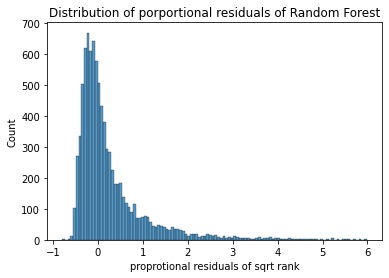

In [49]:
residuals = (y_train_pred - y_train) / np.abs(y_train)
sns.histplot(residuals[residuals < 6])
plt.xlabel('proprotional residuals of sqrt rank')
plt.title('Distribution of porportional residuals of Random Forest')

Text(0.5, 1.0, 'Distribution of porportional residuals of Random Forest')

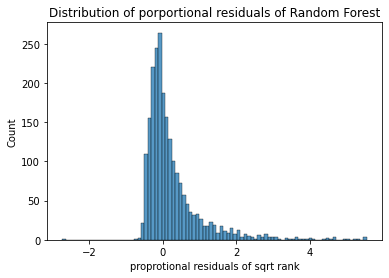

In [50]:
residuals = (y_test_pred - y_test) / np.abs(y_test)
sns.histplot(residuals[residuals < 6])
plt.xlabel('proprotional residuals of sqrt rank')
plt.title('Distribution of porportional residuals of Random Forest')

### Modeling Summary

Here are a few components your notebook must address:
- What type of machine learning problem are you investigating?
    - This is a supervised machine learning problem, with a regression model.
- What model do you plan on using and why?
    - We tried using ridge regression, soft-margin SVM, and vanilla random forest. Ridge regression was the most basic model, SVM because we believed nonlinear kernels could help reduce model bias, and random forest because it could combine features in nonlinear fashions even better.
- Does your model require hyperparameter tuning? If so, how do you approach it?
    - We used built-in cross-validation with ridge regression, but because SVMs and random forest take much longer to train, we used manual validation on test $r^2$. Ridge and SVM each had one hyperparameter that controls the degree of regularization. Random forests used three hyperparameters, number of estimators, maximum tree depth, and minimum leaf size.
- How do you engineer the features for your model? What are the rationales behind selecting these features?
    - We selected only features that a product would reasonably have before launch. The price, brand, title, and description were used because they are easy to incorporate (as opposed to the image, for example), and would likely influence the sales performance. The top 100 brands were one-hot encoded. In order to assist linear models in using these features and allow nonlinear functions to be learned, number of times each brand occurred in the test set was added as a feature, as was a binary feature that described whether the brand appeared over 20 times. The price and brand count squared were also added. The 100 most common words in the title and 500 most common words in the describtion were one-hot encoded.
- How do you perform cross validation on your model?
    - We used the `sklearn` built-in cross validation for ridge regression, and manual validation for other models. In manual validation, the test data $r^2$ was used as a metric.
- What loss metrics are you using to evaluate your model?
    - The primary metric used was the correlation coefficient $r^2$, but the root mean square loss and root mean square proportional loss were used (see writeup for formulas).
- From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?
    - All three models were overfitting since they had higher training $r^2$ than test $r^2$, but the variance was not so high as to make predictions useless. The random forest in particular had the highest tendency to overfit. We aimed for highest test $r^2$ to prevent the models from overfitting too much.
    - All three models also had relatively high bias, since even their training $r^2$ was not very high, but this was to be expected and is justified in the writeup.
- How would you improve your model based on the outcome?
    - We might need to add more features (perhaps taking more brands and title/description words) and add more nonlinearity (other functional transformations on the features). We could also look into the unused features that are harder to incorporate, such as image and technical description. We might also explore using a deep neural network for maximum expressiveness.